In [1]:
import struct
from utils.Auger.SD import *

# see CDAS git /Raid/src/Utils/CL/cl_msg_unknown_pack.h
def read_package(f) -> dict:

    package = {}

    # pack Header
    LsId = int.from_bytes(f.read(2), byteorder='little')
    n_packs = int.from_bytes(f.read(2), byteorder='little')
    timestamp_sec = int.from_bytes(f.read(4), byteorder='little')
    timestamp_nsec = int.from_bytes(f.read(4), byteorder='little')
    total_size = int.from_bytes(f.read(4), byteorder='little')
    rv = LsId, None

    for i in range(n_packs):

        # header i
        type = int.from_bytes(f.read(4), byteorder='little')
        version = int.from_bytes(f.read(4), byteorder='little')
        size = int.from_bytes(f.read(4), byteorder='little')
        data = f.read(size)

        # package[str(i)] = {'type': type,
        #                 'version': version,
        #                 'size': size,
        #                 'data': data}

        # only return the data we're interested in
        if type == 8 and version == 2:
            rv = LsId, data
    
    return rv

# before_official_daq = [] 
# with open('/home/filip/Desktop/monitoring_packs/monit_2024_12_05.packs.nobackup', 'rb') as f:
#     while f.read(8) == b'!monit!!':
#         before_official_daq.append(read_package(f))

# official_daq = [] 
# with open('/home/filip/Desktop/monitoring_packs/monit_2024_12_06.packs.nobackup', 'rb') as f:
#     while f.read(8) == b'!monit!!':
#         official_daq.append(read_package(f)) 

13:13:48 (   +1.3s) [INFO   ] -- import logging
13:13:48 (   +73ms) [INFO   ] -- import numpy as np
13:13:48 (    +9ms) [INFO   ] -- import uncertainties
13:13:49 (  +175ms) [INFO   ] -- import pandas as pd
13:13:49 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
13:13:49 (    +1ms) [INFO   ] -- import binaries.tools as tools
13:13:49 (  +505ms) [INFO   ] -- import matplotlib.pyplot as plt
13:13:49 (   +22ms) [INFO   ] -- import seaborn as so
13:13:49 (    +1ms) [INFO   ] -- import plotting.tools as plot
13:13:49 (    +5ms) [DEBUG  ] -- font size set to 9.5
13:13:49 (    +0ms) [DEBUG  ] -- label size set to 13.0
13:13:49 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
13:13:49 (    +0ms) [DEBUG  ] -- markersize set to 2.0
13:13:49 (    +1ms) [DEBUG  ] -- usetex set to False


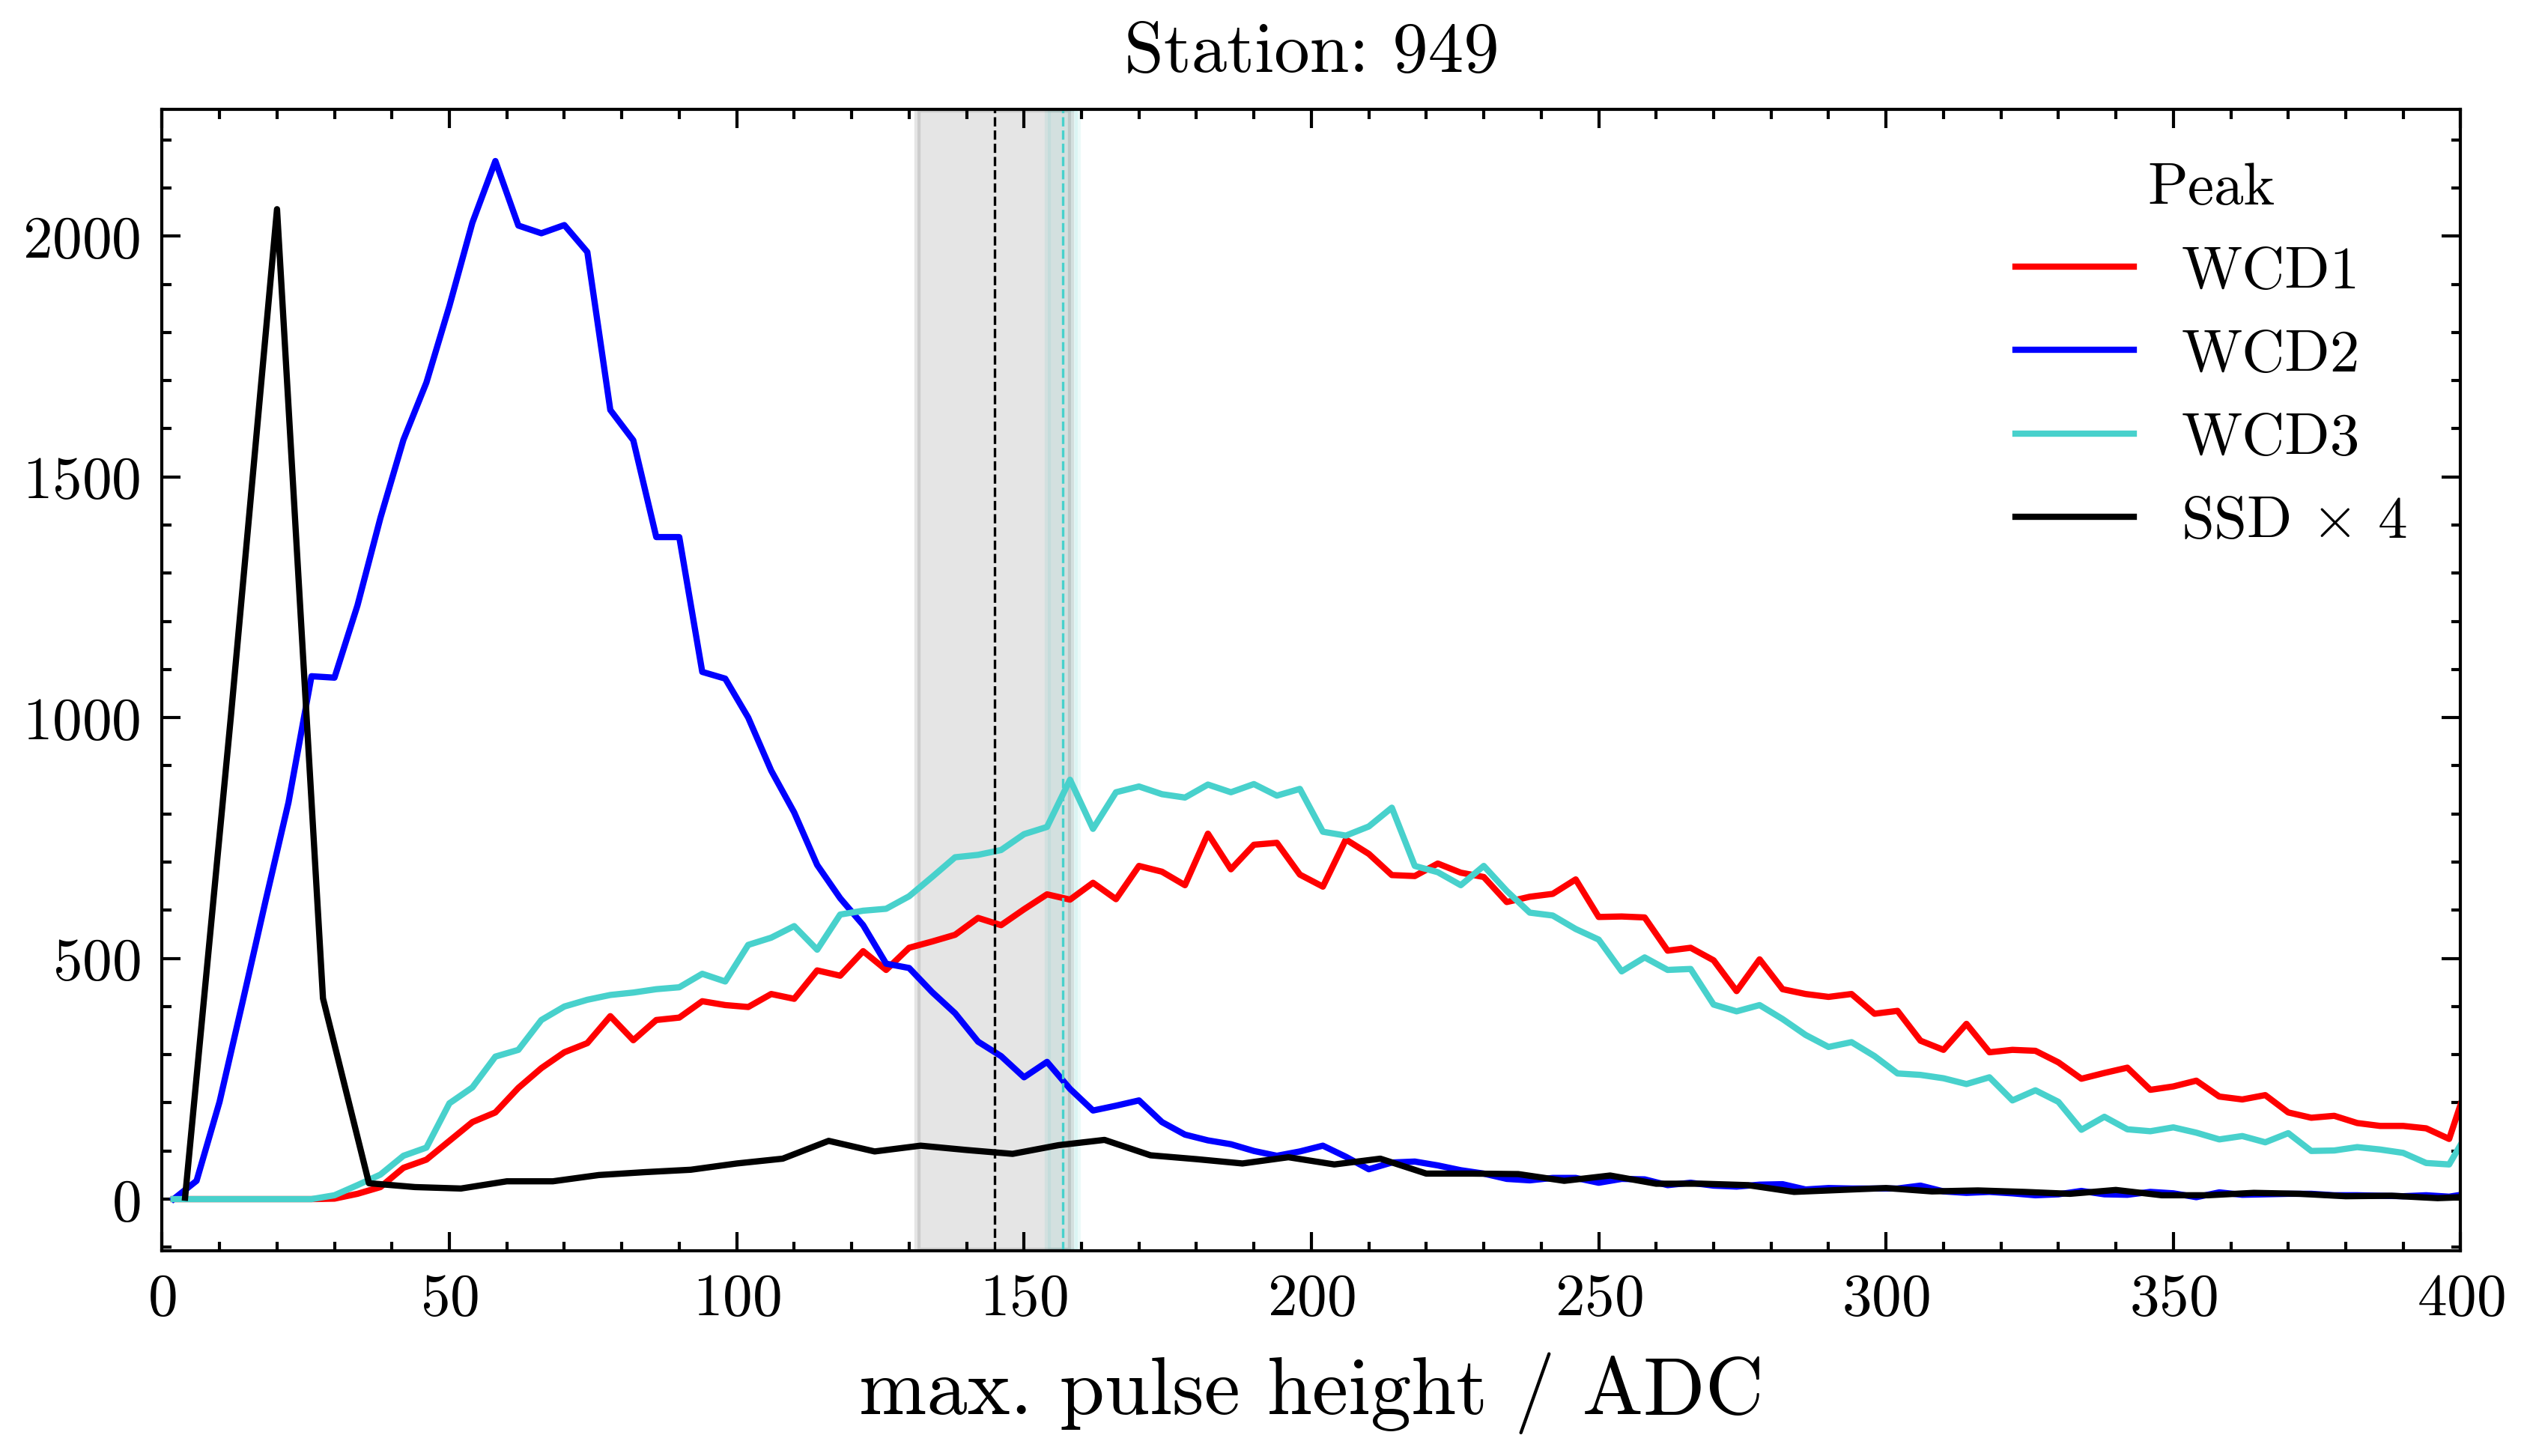

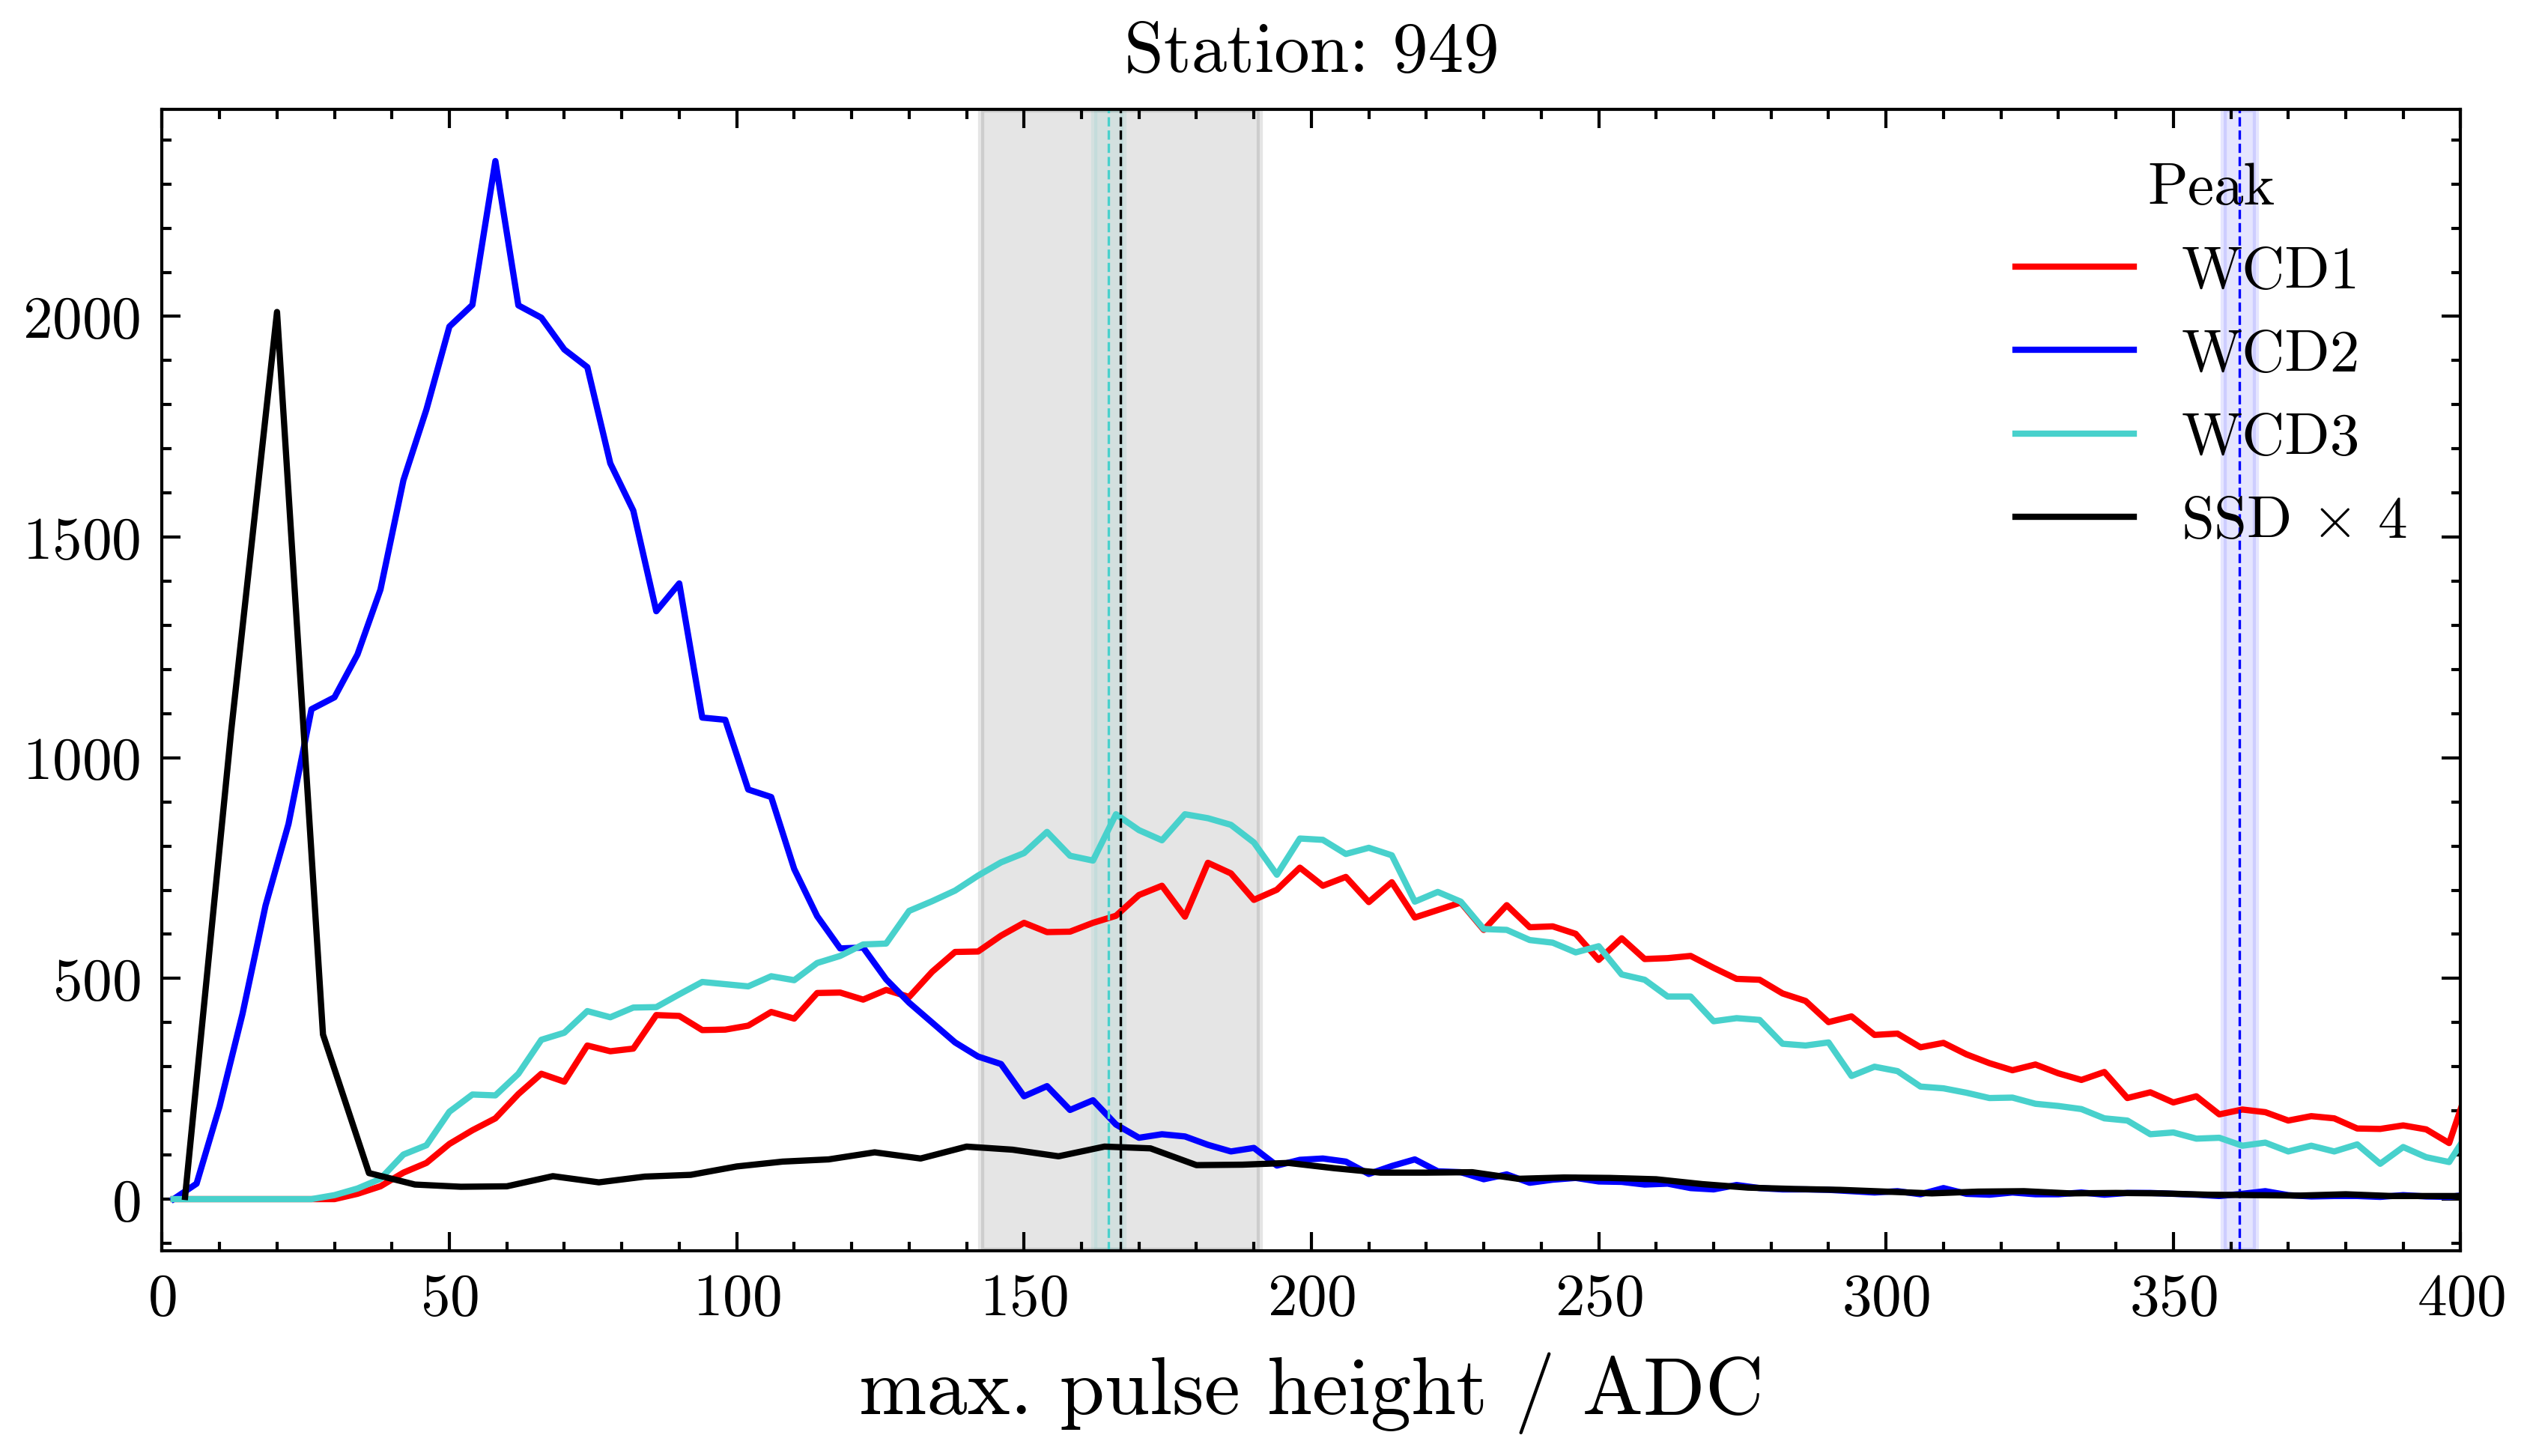

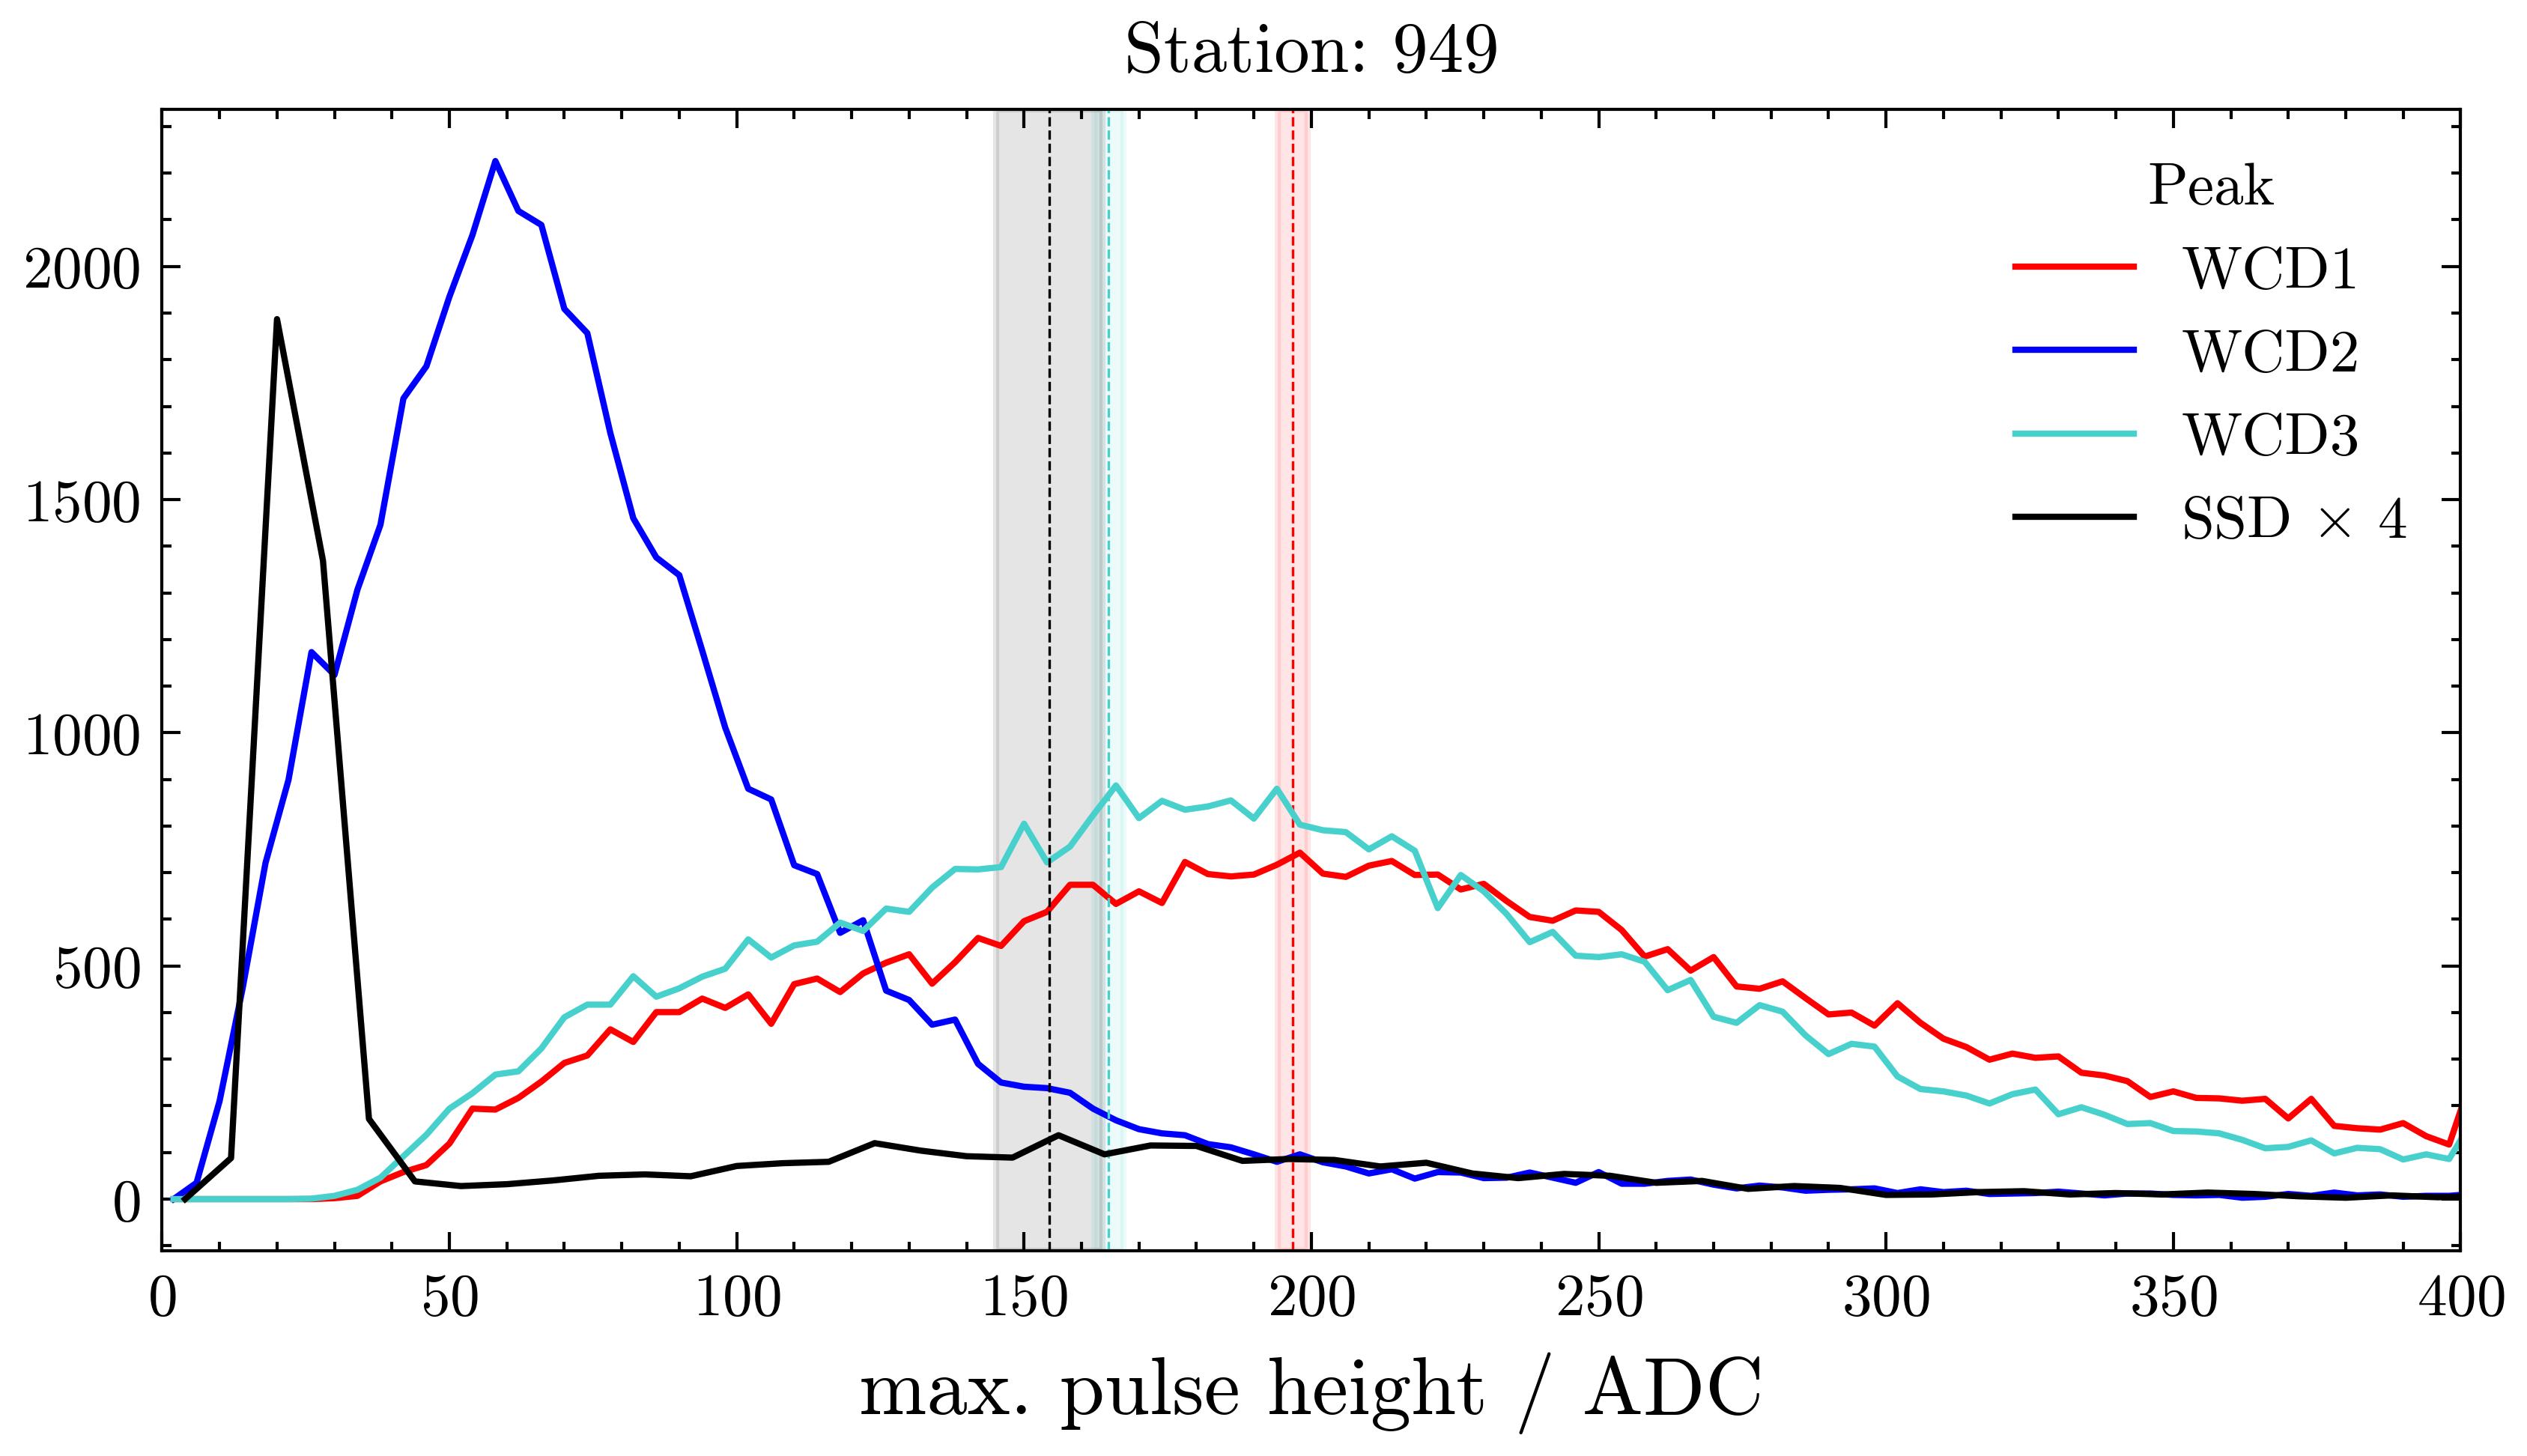

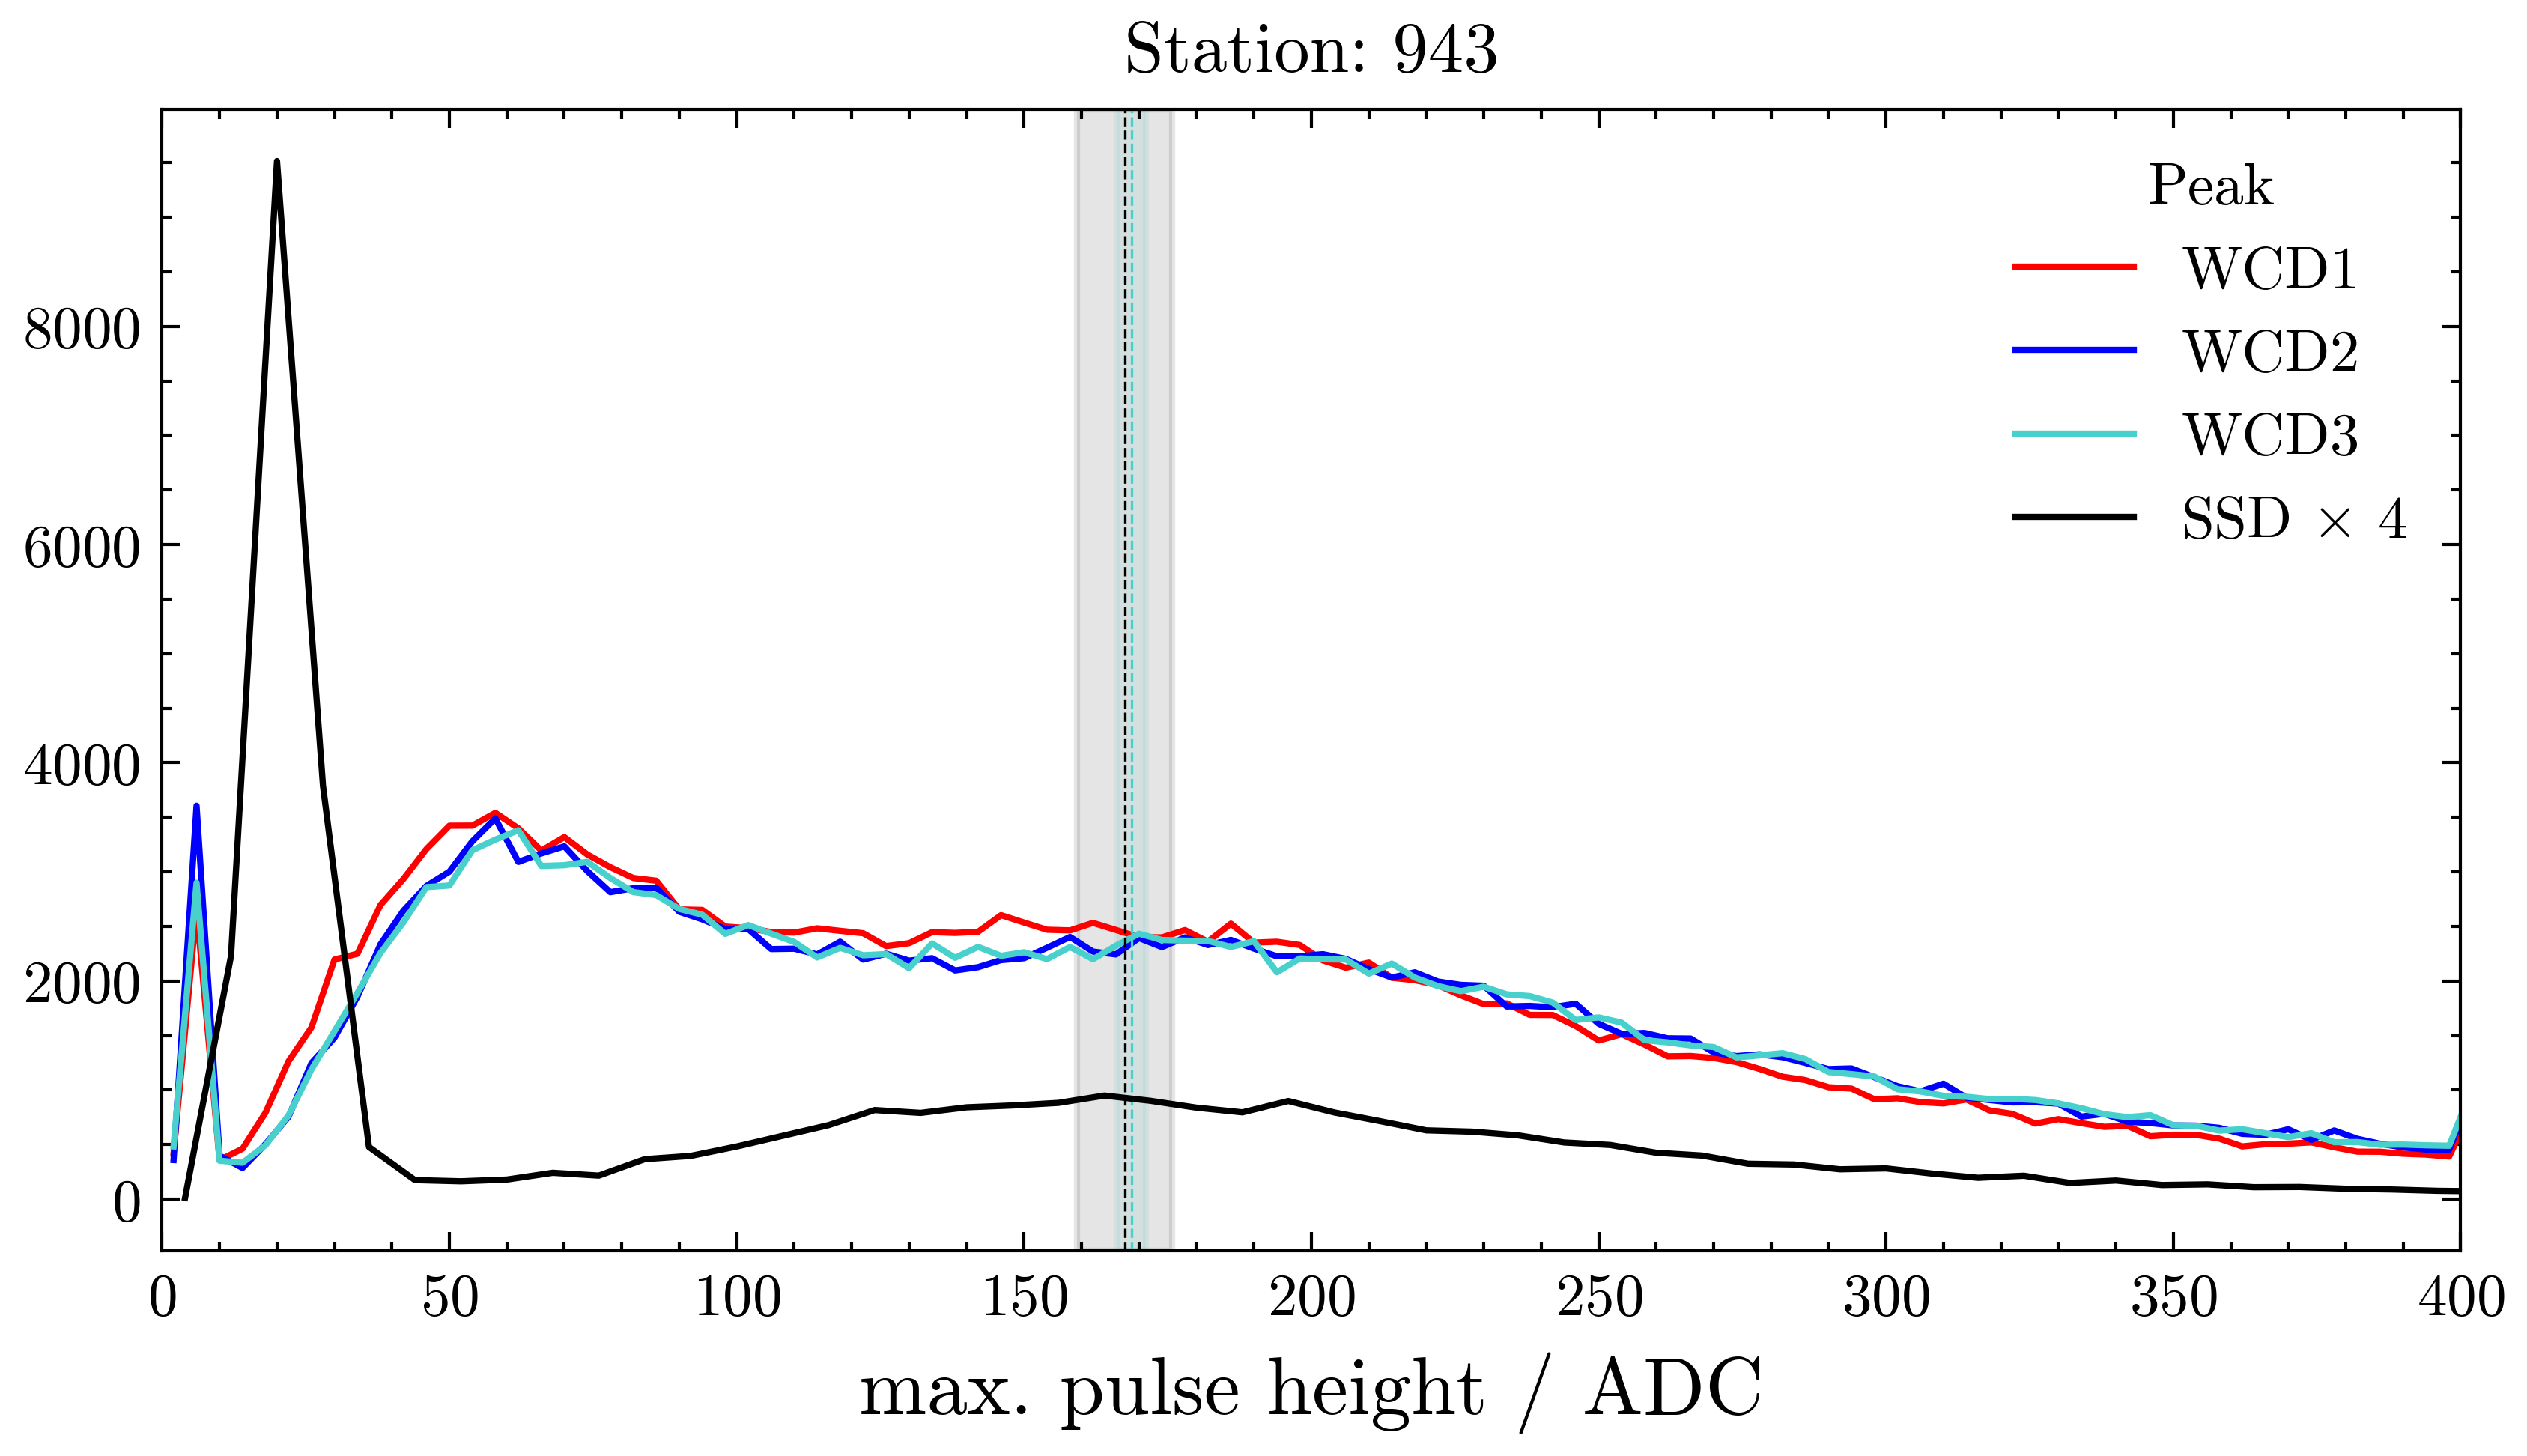

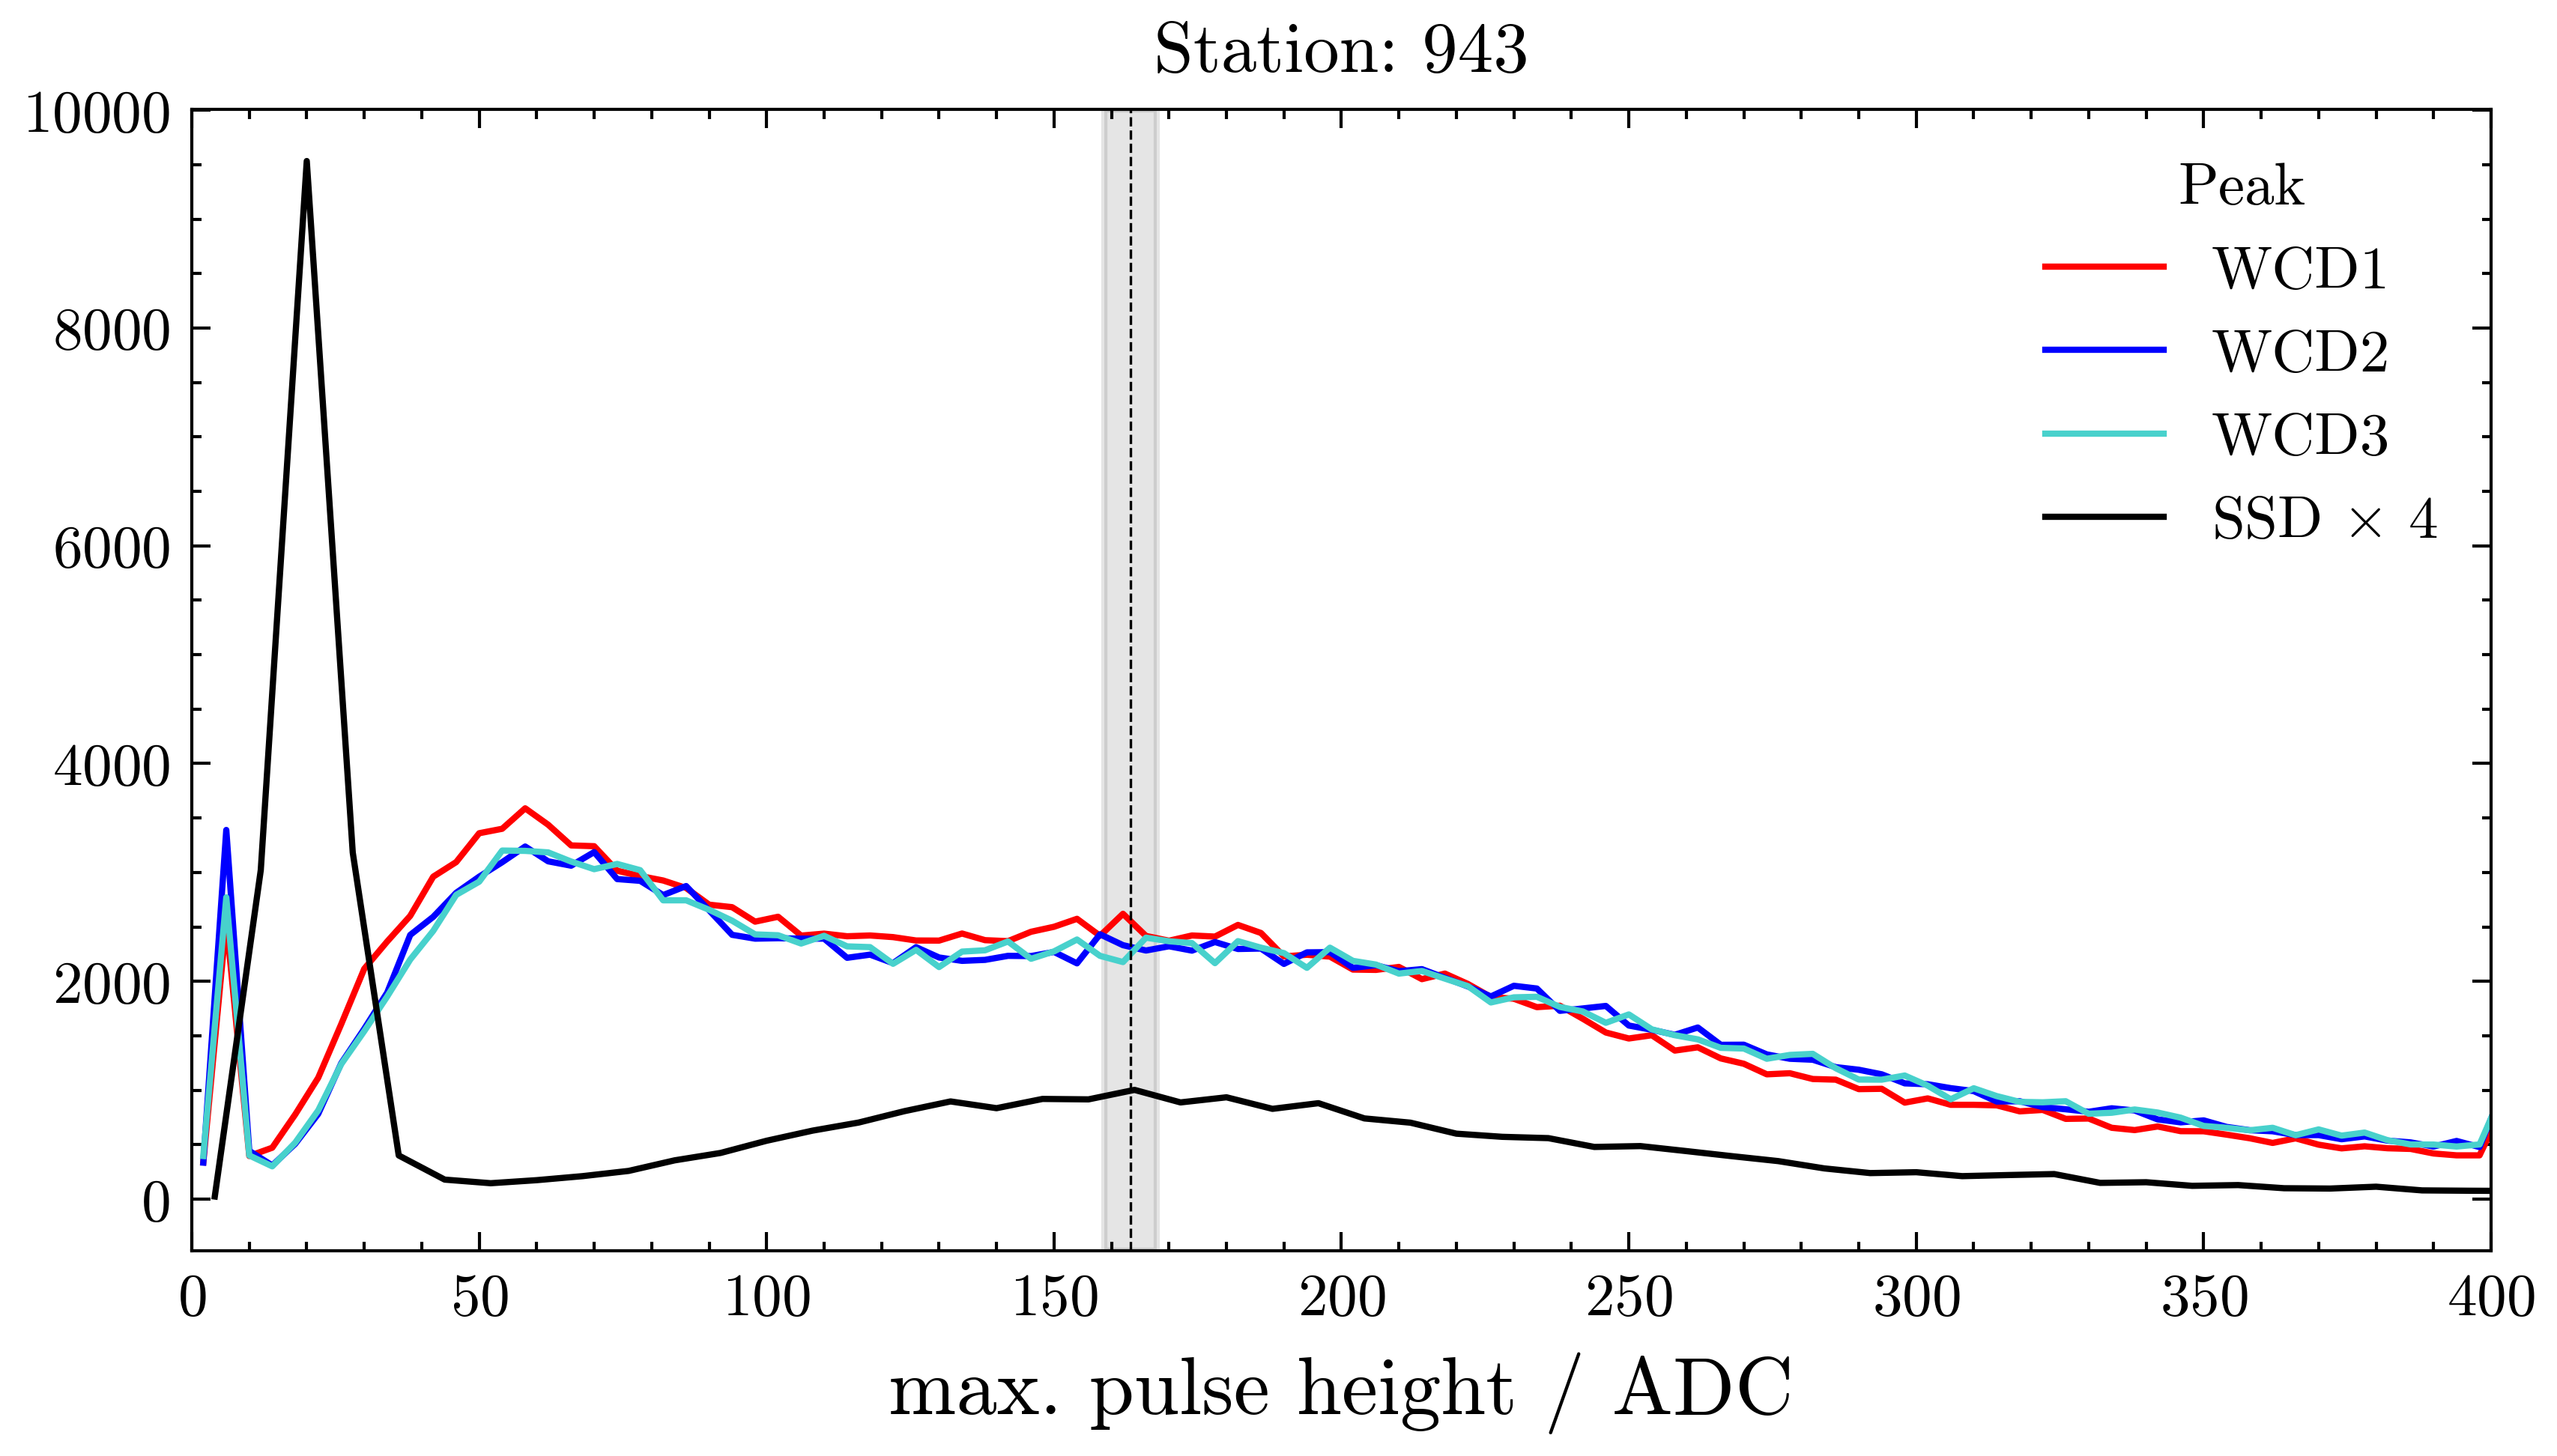

In [5]:
data = read_histos('/home/filip/phd-thesis/Projects/SSDOnlineCalib/fitSDHistoFiles/python/peak.txt')

official_daq = []
for day in [6, 7]:
    try:
        with open(f'/home/filip/Desktop/unread_packages/monit_2024_12_{day:02}.packs.nobackup', 'rb') as f:
            while f.read(8) == b'!monit!!':
                official_daq.append(read_package(f))

    except FileNotFoundError as e: print(e)

histo_peaks = {
    943: [],
    949: [],
}
histo_timestamps = {
    943: [],
    949: [],
}


count_example = 0
for event in data:
    if histo_peaks.get(id := event['id'], None) is None: continue

    histo = SdHisto(peak=event['data'])
    histo_peaks[event['id']].append(histo()['peak'][-1])
    histo_timestamps[event['id']].append(event['timestamp'])

    if count_example < 5:
        histo.plot()
        plt.gca().set_title(f"Station: {event['id']}")
        # plt.gca().set_yscale('log')
        count_example += 1

# monit = Monit(2024, 12, 6)

In [ ]:
from utils.binaries import *
from utils.plotting import *
from datetime import datetime
import matplotlib.dates as mdates

start_ack = datetime.strptime("Dec 06 08:00:27 2024", "%b %d %H:%M:%S %Y").timestamp()  # from IkLog

fig, axes = plt.subplots(7, 1, sharex=True, sharey=True)

LsId = [943, 944, 945, 948, 949, 954, 972]
noSSD = [948, 945, 972]
peaks = {id: [] for id in LsId}

convert = lambda d: [struct.unpack('d', d[i:i+8])[0] for i in range(0, len(d), 8)]

for e in official_daq:
    if e[0] == 136: continue
    elif e[1] is None: peaks[e[0]]; continue
    peaks[e[0]].append(convert(e[1]))

for (id, val), ax in zip(peaks.items(), axes):
    # for i in range(4):
    #    ax.plot(range(len(val)), np.array(val)[:, i], label=i)

    if id in noSSD: ax.set_facecolor('#808080')
    ax.plot(plot.to_datetime(start_ack + 402 * np.arange(len(val))), np.array(val)[:, 3], ls='solid', marker='none', label='CalMonSvr')

    if histo_timestamps.get(id, None) is None: continue

    ax.errorbar(plot.to_datetime(histo_timestamps[id]), [v.n for v in histo_peaks[id]], yerr=[v.std_dev for v in histo_peaks[id]],
                fmt='ro', capsize=1, capthick=0.6, lw=0.6, markersize=0.4, label='T3 histograms')
    
    if id == 943:
        ax.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=2)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)

_ = ax.set_xlabel("CDAS time / HH:MM")

In [ ]:
# focus plot for two functioning stations

fig, axes = plt.subplots(4, 1, sharex=True, height_ratios=[1, 0.4, 1, 0.4])

axes = np.split(axes, 2)
ids = [943, 949]

for id, axs in zip([943, 949], axes):
    ax1, ax2 = axs

    calmon_peak = np.array(peaks[id])[:, 3]
    histo_peak = histo_peaks[id]
    histo_time = histo_timestamps[id]
    calmon_time = start_ack + 402 * np.arange(len(calmon_peak))

    ax1.plot(plot.to_datetime(calmon_time), np.array(calmon_peak), ls='solid', marker='none')

    ax1.errorbar(plot.to_datetime(histo_time), [v.n for v in histo_peak], yerr=[v.std_dev for v in histo_peak],
                fmt='ro', capsize=1, capthick=0.8, lw=0.8, markersize=1.4)
    
    get_closest_idx = lambda t: np.argmin(np.abs(calmon_time - t))


    diff, timestamps = [], []
    for x, y in zip(histo_time, histo_peak):
        i = get_closest_idx(x)

        if calmon_time[i] - x > 600: continue

        diff.append((calmon_peak[i] - y.n)/y.n)
        timestamps.append(calmon_time[i])

    ax2.scatter(plot.to_datetime(timestamps), diff, alpha=0.5, s=0.5)
    ax2.axhline(0, c='k', ls='--')

    ax1.set_ylabel('ADC', labelpad=20)
    ax2.set_ylabel(r'$\Delta$ / %')
    ax1.legend(title=f"{id = }", loc='upper left')

plot.apply_datetime_format(ax2)

In [ ]:
# checking ssd histos in stations that have ssd but look wrong

for i, event in enumerate(data):
    if event['id'] in noSSD or event['id'] in [943, 949]: continue

    example_histo = SdHisto(peak = event['data'])
    example_histo.fit()
    example_histo.plot()
    plt.gca().set_title(f'Station: {event["id"]}')

    if i > 10: break